In [1]:
import numpy as onp
import jax
import jax.numpy as np

from jax import lax, random
from jax.api import grad, jit, vmap
from jax.config import config
from jax.experimental import optimizers

config.update('jax_enable_x64', True)

from functools import partial
from jax import random

from neural_tangents import stax

# Attacking
from jax.experimental.stax import logsoftmax
from cleverhans.utils import clip_eta, one_hot

# Plotting
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import *
sns.set_style(style='white')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

"""
diag_reg:
    a scalar representing the strength of the diagonal regularization for
    `k_train_train`, i.e. computing `k_train_train + diag_reg * I` during
    Cholesky factorization or eigendecomposition.
"""
diag_reg = 1e-5
batch_size = 30

# import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".5"

# data

In [2]:
x_train_all, y_train_all, x_test_all, y_test_all = tuple(onp.array(x) for x in get_dataset('mnist', None, None, 
                                                                                  do_flatten_and_normalize=False))
class_num = 10

In [3]:
# shuffle
seed = 0
x_train_all, y_train_all = shaffle(x_train_all, y_train_all, seed)

In [4]:
# down sample

train_size = 4096
x_train = x_train_all[:train_size]
y_train = y_train_all[:train_size]

test_size = 512
x_test = x_test_all[:test_size]
y_test = y_test_all[:test_size]

# shape = (x_train.shape[0], 32, 32, 3)

In [5]:
device_id = jax.devices()[0]

In [6]:
# move to gpu

x_train = jax.device_put(x_train, device=device_id)
y_train = jax.device_put(y_train, device=device_id)

x_test = jax.device_put(x_test, device=device_id)
y_test = jax.device_put(y_test, device=device_id)

# model

In [7]:
def accuracy(mean, ys):
    return np.mean(np.argmax(mean, axis=-1) == np.argmax(ys, axis=-1))

In [8]:
def DenseBlock(neurons, W_std, b_std):
    return stax.serial(stax.Dense(neurons, W_std, b_std), 
                       stax.Erf())

def DenseGroup(n, neurons, W_std, b_std):
    blocks = []
    for _ in range(n):
        blocks += [DenseBlock(neurons, W_std, b_std)]
    # final layer    
    blocks += [stax.Dense(class_num, W_std, b_std)]
    return stax.serial(*blocks)

In [9]:
def model_fn(kernel_fn, obj_fn, x_train=None, x_test=None, fx_train_0=0., fx_test_0=0., t=None):
    # Kernel
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    
    if obj_fn == 'train':
        return ntk_train_train
    elif obj_fn == 'test':
        ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
        # Prediction
        predict_fn = nt.predict.gradient_descent_mse(ntk_train_train, y_train, diag_reg=diag_reg) # no convariance
        return predict_fn(t, fx_train_0, fx_test_0, ntk_test_train) # fx_train_0, fx_test_0 = (0, 0) for infinite width
    else:
        raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")

In [10]:
model_fn = jit(model_fn, static_argnums=(0, 1), device=device_id)

# loss

In [11]:
@jit
def l2_loss_v1(logits, labels, weighting=1):
    """
    Tensorflow version of L2 loss (without sqrt)
    """
    return np.sum(((logits - labels)**2) * weighting) / 2
    
@jit
def l2_loss_v2(logits, lables):
    """
    Normal L2 loss
    """
    return np.linalg.norm(logits - labels)

@jit
def cross_entropy_loss(logits, lables):
    return -np.sum(logsoftmax(logits) * lables)
    
@jit
def mse_loss(logits, lables):
    return 0.5 * np.mean((logits - lables) ** 2)

In [12]:
def fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, grads_c_fn=None, x_train=None, y_train=None, x_test=None, 
                         y=None, t=None, c=None, update_c=False, loss_weighting=None, phase=None, 
                         fx_train_0=0., fx_test_0=0., eps=0.3, norm=np.inf, clip_min=None, clip_max=None, targeted=False):
    """
    JAX implementation of the Fast Gradient Method.
    :param model_fn: a callable that takes an input tensor and returns the model logits.
    :param x: input tensor.
    :param eps: epsilon (input variation parameter); see https://arxiv.org/abs/1412.6572.
    :param norm: Order of the norm (mimics NumPy). Possible values: np.inf or 2.
    :param clip_min: (optional) float. Minimum float value for adversarial example components.
    :param clip_max: (optional) float. Maximum float value for adversarial example components.
    :param y: (optional) Tensor with one-hot true labels. If targeted is true, then provide the
            target one-hot label. Otherwise, only provide this parameter if you'd like to use true
            labels when crafting adversarial samples. Otherwise, model predictions are used
            as labels to avoid the "label leaking" effect (explained in this paper:
            https://arxiv.org/abs/1611.01236). Default is None. This argument does not have
            to be a binary one-hot label (e.g., [0, 1, 0, 0]), it can be floating points values
            that sum up to 1 (e.g., [0.05, 0.85, 0.05, 0.05]).
    :param targeted: (optional) bool. Is the attack targeted or untargeted?
            Untargeted, the default, will try to make the label incorrect.
            Targeted will instead try to move in the direction of being more like y.
    :return: a tensor for the adversarial example
    """
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")
        
    x = x_test
        
    # Obj - Θ(test, train)Θ(train, train)^-1
    # test independent
    if obj_fn == 'test_col':
        grads_c = 0
        grads = grads_fn(x_train, x_test, kernel_fn, c)
        if update_c is True:
            grads_c += grads_c_fn(x_train, x_test, kernel_fn, c)
                
        perturbation_c = 1e-5 * np.sign(grads_c) # grads_c = 5e-2 * np.sign(grads_c)
        
        
    # Obj - Θ(test, train)Θ(train, train)^-1 y_train
    else:
        raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")

    axis = list(range(1, len(grads.shape)))
    eps_div = 1e-12
    
    if norm == np.inf:
        perturbation = eps * np.sign(grads)
    elif norm == 1:
        raise NotImplementedError("L_1 norm has not been implemented yet.")
    elif norm == 2:
        square = np.maximum(eps_div, np.sum(np.square(grads), axis=axis, keepdims=True))
        perturbation = grads / np.sqrt(square)
    
    # TODO
    adv_x = x + perturbation
    
    # If clipping is needed, reset all values outside of [clip_min, clip_max]
    if (clip_min is not None) or (clip_max is not None):
        # We don't currently support one-sided clipping
        assert clip_min is not None and clip_max is not None
        adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
    
    if update_c:
        c += perturbation_c
        return x, c
    
    return adv_x, c

In [13]:
def projected_gradient_descent(model_fn, kernel_fn, obj_fn, grads_fn, grads_c_fn=None, x_train=None, y_train=None,
                               x_test=None, y=None, t=None, c=None, update_c=None, loss_weighting=None, 
                               phase=None, fx_train_0=0., fx_test_0=0., eps=0.3, eps_iter=0.03, nb_iter=10, norm=np.inf, 
                               clip_min=None, clip_max=None, targeted=False, rand_init=None, rand_minmax=0.3):
    """
    This class implements either the Basic Iterative Method
    (Kurakin et al. 2016) when rand_init is set to 0. or the
    Madry et al. (2017) method when rand_minmax is larger than 0.
    Paper link (Kurakin et al. 2016): https://arxiv.org/pdf/1607.02533.pdf
    Paper link (Madry et al. 2017): https://arxiv.org/pdf/1706.06083.pdf
    :param model_fn: a callable that takes an input tensor and returns the model logits.
    :param x: input tensor.
    :param eps: epsilon (input variation parameter); see https://arxiv.org/abs/1412.6572.
    :param eps_iter: step size for each attack iteration
    :param nb_iter: Number of attack iterations.
    :param norm: Order of the norm (mimics NumPy). Possible values: np.inf or 2.
    :param clip_min: (optional) float. Minimum float value for adversarial example components.
    :param clip_max: (optional) float. Maximum float value for adversarial example components.
    :param y: (optional) Tensor with true labels. If targeted is true, then provide the
            target label. Otherwise, only provide this parameter if you'd like to use true
            labels when crafting adversarial samples. Otherwise, model predictions are used
            as labels to avoid the "label leaking" effect (explained in this paper:
            https://arxiv.org/abs/1611.01236). Default is None.
    :param targeted: (optional) bool. Is the attack targeted or untargeted?
            Untargeted, the default, will try to make the label incorrect.
            Targeted will instead try to move in the direction of being more like y.
    :return: a tensor for the adversarial example
    """

    assert eps_iter <= eps, (eps_iter, eps)
    if norm == 1:
        raise NotImplementedError("It's not clear that FGM is a good inner loop"
                                  " step for PGD when norm=1, because norm=1 FGM "
                                  " changes only one pixel at a time. We need "
                                  " to rigorously test a strong norm=1 PGD "
                                  "before enabling this feature.")
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")
        
    x = x_test
    
    # Initialize loop variables
    if rand_init:
        rand_minmax = eps
        eta = random.uniform(new_key, x.shape, minval=-rand_minmax, maxval=rand_minmax)
    else:
        eta = np.zeros_like(x)

    # Clip eta
    eta = clip_eta(eta, norm, eps)
    adv_x = x + eta
    if clip_min is not None or clip_max is not None:
        adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
        
    for i in range(nb_iter):
        if update_c is not None and (i+1) % update_c == 0:
            adv_x, c = fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, grads_c_fn, x_train, y_train, adv_x, 
                                            y, t, c, True, loss_weighting, phase, fx_train_0, fx_test_0, eps_iter, norm, 
                                            clip_min, clip_max, targeted)
        else:
            adv_x, c = fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, grads_c_fn, x_train, y_train, adv_x, 
                                            y, t, c, False, loss_weighting, phase, fx_train_0, fx_test_0, eps_iter, norm, 
                                            clip_min, clip_max, targeted)

        # Clipping perturbation eta to norm norm ball
        eta = adv_x - x
        eta = clip_eta(eta, norm, eps)
        adv_x = x + eta

        # Redo the clipping.
        # FGM already did it, but subtracting and re-adding eta can add some
        # small numerical error.
        if clip_min is not None or clip_max is not None:
            adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
    
    return adv_x, c

# Attack Hyperparameters

In [14]:
attack_type = ["Clean", "FGSM", "PGD-10", "PGD-100"]

####### MNIST #######
eps = 0.3
eps_iter_10 = (eps/10)*1.1
eps_iter_100 = (eps/100)*1.1
eps_iter_1000 = (eps/1000)*1.1
####### MNIST #######

####### CIFAR #######
# eps = 16/255
# eps_iter_10 = (eps/10)*1.1
# eps_iter_100 = (eps/100)*1.1
####### CIFAR #######

In [15]:
def evaluate(x_train, x_test, model_fn, kernel_fn, t=None, c=0, attack_type=None):
    y_train_predict, y_test_predict = model_fn(kernel_fn, 'test', x_train, x_test, t=t)
    acc = accuracy(y_test_predict, y_test)
    print("Robustness({:s}): {:.2f}".format(attack_type, acc))
    
    return acc

# adv_x generation

In [16]:
def white_box_model(W=1.76, b=0.18, layer=10):
    key = random.PRNGKey(0)
    W_std = np.sqrt(W)
    b_std = np.sqrt(b)

    init_fn, apply_fn, kernel_fn = stax.serial(DenseGroup(layer, 1024, W_std, b_std))

    # Inference with a single infinite width / linearized network
    # kernel_fn(x_train, x_test, 'ntk' or 'nngp')
    kernel_fn = jit(kernel_fn, static_argnums=(2,))
    return kernel_fn

In [17]:
def gen_adv_x(model_layer, t=None, d='col'):

    kernel_fn = white_box_model(layer=model_layer)
    key = random.PRNGKey(0)
    
    def model_fn(kernel_fn, obj_fn, x_train=None, x_test=None, fx_train_0=0., fx_test_0=0., t=None):
        # Kernel
        ntk_train_train = kernel_fn(x_train, x_train, 'ntk')

        if obj_fn == 'train':
            return ntk_train_train
        elif obj_fn == 'test':
            ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
            # Prediction
            predict_fn = nt.predict.gradient_descent_mse(ntk_train_train, y_train, diag_reg=diag_reg) # no convariance
            return predict_fn(t, fx_train_0, fx_test_0, ntk_test_train) # fx_train_0, fx_test_0 = (0, 0) for infinite width
        else:
            raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")
        
    def inv(k):
        #inverse with diag_reg
        return np.linalg.inv(k + diag_reg * np.eye(k.shape[0]))

    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    ntk_train_train_inv = inv(ntk_train_train)
    
    ntk_train_train = jax.device_put(ntk_train_train, device_id)
    ntk_train_train_inv = jax.device_put(ntk_train_train_inv, device_id)

    def test_loss_adv_matrix(x_train, x_test, kernel_fn, c, t=None, 
                             ntk_train_train_inv=ntk_train_train_inv):
        # Kernel -> matrix of constant c
        ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
        mean_predictor = np.einsum('ij,jk->ik', ntk_test_train, ntk_train_train_inv)

        # Loss
        loss = - l2_loss_v1(mean_predictor, np.ones_like(mean_predictor)*c)
        return loss

    # grad for x_test
    test_grads_fn = jit(grad(test_loss_adv_matrix, argnums=1), static_argnums=(0, 2), device=device_id)
    test_c_grads_fn = jit(grad(test_loss_adv_matrix, argnums=3), static_argnums=(0, 2), device=device_id)

    def test_loss_adv_col(x_train, x_test, kernel_fn, c, t=None,
                         ntk_train_train_inv=ntk_train_train_inv):
        """
        Kernel -> matrix with constant cols

        c is a vector of constant. c.shape should be (1, test_size)

        """ 
        ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
        mean_predictor = np.einsum('ij,jk->ik', ntk_test_train, ntk_train_train_inv)

        # Loss
        loss = - l2_loss_v1(mean_predictor, np.ones_like(mean_predictor)*c.T)
        return loss

    # grad for x_test
    test_col_wise_grads_fn = jit(grad(test_loss_adv_col, argnums=1), static_argnums=(2,), device=device_id)
    test_col_wise_c_grads_fn = jit(grad(test_loss_adv_col, argnums=3), static_argnums=(2,), device=device_id)

    def test_loss_adv_row(x_train, x_test, kernel_fn, c, t=None,
                         ntk_train_train_inv=ntk_train_train_inv):
        """
        Kernel -> matrix with constant rows

        c is a vector of constant. c.shape should be (1, train_size)

        """
        # ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
        ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
        mean_predictor = np.einsum('ij,jk->ik', ntk_test_train, ntk_train_train_inv)

        # Loss
        loss = - l2_loss_v1(mean_predictor, np.ones_like(mean_predictor)*c)
        return loss
    
    # grad for x_test
    test_row_wise_grads_fn = jit(grad(test_loss_adv_row, argnums=1), static_argnums=(2,), device=device_id)
    test_row_wise_c_grads_fn = jit(grad(test_loss_adv_row, argnums=3), static_argnums=(2,), device=device_id)
    
    def mean_predictor(x_train, x_test, kernel_fn, c=None, row=False, col=False, get_sample=False,
                   ntk_train_train_inv=ntk_train_train_inv):
        """
        return Θ(test, train)Θ(train, train)^-1 and 
        || # Θ(test, train)Θ(train, train)^-1 - target ||

        """
        if not row and not col:
            raise ValueError("at least one of row or col should be true")

        # Kernel
        ntk_test_train = kernel_fn(x_test, x_train, 'ntk')

        # Θ(test, train)Θ(train, train)^-1
        mean_predictor = np.einsum('ij,jk->ik', ntk_test_train, ntk_train_train_inv)
        loss = 0.0

        if c is None:
            if row ^ col:
                if row:
                    c = np.mean(mean_predictor, axis=0)
                    c = np.reshape(c, (1, -1))
                    loss = l2_loss_v1(mean_predictor, np.ones_like(mean_predictor)*c)
                elif col:
                    c = np.mean(mean_predictor, axis=1)
                    c = np.reshape(c, (1, -1))
                    loss = l2_loss_v1(mean_predictor, np.ones_like(mean_predictor)*c.T)
            else:
                raise ValueError("row xor col not true")

        if get_sample:
            return c

        return loss, mean_predictor

    def get_matrix(adv_x, x_train=x_train, kernel_fn=kernel_fn):
        ntk_test_train = kernel_fn(adv_x, x_train, 'ntk')
        matrix = np.einsum('ij,jk->ik', ntk_test_train, ntk_train_train_inv)
        return matrix
    
    #clean
    evaluate(x_train, x_test, model_fn=model_fn, kernel_fn=kernel_fn, t=t, c=0, attack_type='Clean')
    # m_clean = get_matrix(x_test)
    # np.mean(np.std(m_clean, axis=1))

    if d == 'col':
        c_sample = mean_predictor(x_train, x_test, kernel_fn, col=True, get_sample=True)
    elif d == 'row':
        c_sample = mean_predictor(x_train, x_test, kernel_fn, row=True, get_sample=True)

    c = c_sample.reshape((1, -1))

    # FGSM
    adv_x_FGSM, c = fast_gradient_method(model_fn=model_fn, kernel_fn=kernel_fn, obj_fn='test_col', 
                                         grads_fn=test_row_wise_grads_fn, grads_c_fn=test_row_wise_c_grads_fn,
                                         x_train=x_train, y_train=y_train, x_test=x_test, y=y_test, t=t, c=c,
                                         eps=eps, clip_min=0, clip_max=1)

    evaluate(x_train, adv_x_FGSM, model_fn=model_fn, kernel_fn=kernel_fn, t=t, c=c, attack_type='FGSM')
    # m_FGSM = get_matrix(adv_x_FGSM)
    # np.mean(np.std(m_FGSM, axis=1))

    # PGD 10
    key, new_key = random.split(key)
    c = c_sample.reshape((1, -1))
    adv_x_PGD_10 , c = projected_gradient_descent(model_fn=model_fn, kernel_fn=kernel_fn, obj_fn='test_col', 
                                                  grads_fn=test_row_wise_grads_fn, grads_c_fn=test_row_wise_c_grads_fn,
                                                  x_train=x_train, y_train=y_train, x_test=x_test, y=y_test, t=t, c=c, update_c=3, 
                                                  eps=eps, eps_iter=eps_iter_10, nb_iter=10, 
                                                  clip_min=0, clip_max=1, rand_init=None, rand_minmax=eps)

    evaluate(x_train, adv_x_PGD_10, model_fn=model_fn, kernel_fn=kernel_fn, t=t, c=c, attack_type='PGD-10')

    # m_PGD_10 = get_matrix(adv_x_PGD_10)
    # np.mean(np.std(m_PGD_10, axis=1))

    # PGD 100
    key, new_key = random.split(key)
    c = c_sample.reshape((1, -1))
    adv_x_PGD_100, c = projected_gradient_descent(model_fn=model_fn, kernel_fn=kernel_fn, obj_fn='test_col', 
                                                  grads_fn=test_row_wise_grads_fn, grads_c_fn=test_row_wise_c_grads_fn,
                                                  x_train=x_train, y_train=y_train, x_test=x_test, y=y_test, t=t, c=c, update_c=3, 
                                                  eps=eps, eps_iter=eps_iter_100, nb_iter=100, 
                                                  clip_min=0, clip_max=1, rand_init=None, rand_minmax=eps)

    evaluate(x_train, adv_x_PGD_100, model_fn=model_fn, kernel_fn=kernel_fn, t=t, c=c, attack_type='PGD-100')

    # m_PGD_100 = get_matrix(adv_x_PGD_100)
    # np.mean(np.std(m_PGD_100, axis=1))
    return adv_x_FGSM, adv_x_PGD_10, adv_x_PGD_100

In [18]:
time_steps = [16**i for i in range(0, 5)]
time_steps.append(np.inf)

In [19]:
import matplotlib.pyplot as plt
img_shape = (28, 28)

In [20]:
def save_samples(arr, attack_type, layer):
    fig, axs = plt.subplots(2, 4, figsize=(6, 3), sharex=True)
    for row, ax in enumerate(axs):
        for idx, a in enumerate(ax):
            img = arr[idx + row*4].reshape(img_shape)
            a.axis('off')
            a.xaxis.set_visible(False)
            a.yaxis.set_visible(False)
            a.imshow(img, cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.savefig("./fig-mnist-row/%s_layer_%d.png"%(attack_type, layer+1), dpi=150)
    plt.show()

# transfer

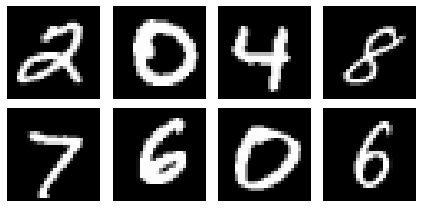

****************
generating adv examples...
base model layer:  0
Robustness(Clean): 0.84
Robustness(FGSM): 0.10
Robustness(PGD-10): 0.54
Robustness(PGD-100): 0.87


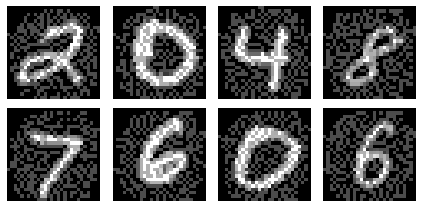

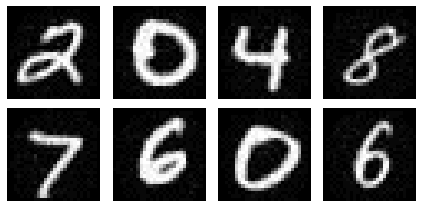

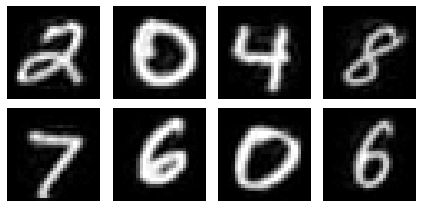

generation done.
starting evaluation.
----------------------
transfer model layer:  0
t:  1
Robustness(Clean): 0.46
Robustness(FGSM): 0.37
Robustness(PGD-10): 0.44
Robustness(PGD-100): 0.43
-------
t:  16
Robustness(Clean): 0.51
Robustness(FGSM): 0.40
Robustness(PGD-10): 0.50
Robustness(PGD-100): 0.49
-------
t:  256
Robustness(Clean): 0.72
Robustness(FGSM): 0.67
Robustness(PGD-10): 0.72
Robustness(PGD-100): 0.72
-------
t:  4096
Robustness(Clean): 0.84
Robustness(FGSM): 0.83
Robustness(PGD-10): 0.85
Robustness(PGD-100): 0.84
-------
t:  65536
Robustness(Clean): 0.87
Robustness(FGSM): 0.79
Robustness(PGD-10): 0.87
Robustness(PGD-100): 0.88
-------
t:  inf
Robustness(Clean): 0.84
Robustness(FGSM): 0.10
Robustness(PGD-10): 0.54
Robustness(PGD-100): 0.87
-------
----------------------
transfer model layer:  5
t:  1
Robustness(Clean): 0.27
Robustness(FGSM): 0.21
Robustness(PGD-10): 0.27
Robustness(PGD-100): 0.25
-------
t:  16
Robustness(Clean): 0.71
Robustness(FGSM): 0.68
Robustness(PGD-1

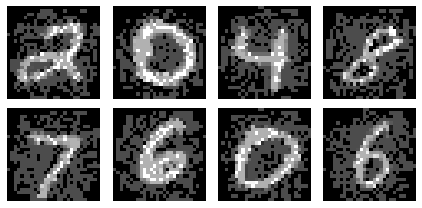

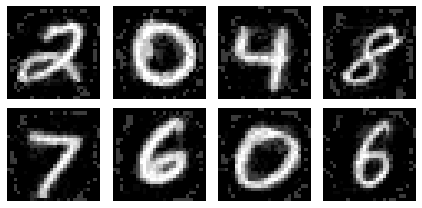

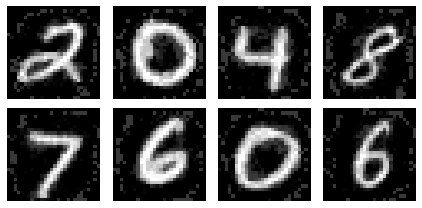

generation done.
starting evaluation.
----------------------
transfer model layer:  0
t:  1
Robustness(Clean): 0.46
Robustness(FGSM): 0.30
Robustness(PGD-10): 0.46
Robustness(PGD-100): 0.46
-------
t:  16
Robustness(Clean): 0.51
Robustness(FGSM): 0.31
Robustness(PGD-10): 0.53
Robustness(PGD-100): 0.54
-------
t:  256
Robustness(Clean): 0.72
Robustness(FGSM): 0.58
Robustness(PGD-10): 0.74
Robustness(PGD-100): 0.74
-------
t:  4096
Robustness(Clean): 0.84
Robustness(FGSM): 0.79
Robustness(PGD-10): 0.87
Robustness(PGD-100): 0.87
-------
t:  65536
Robustness(Clean): 0.87
Robustness(FGSM): 0.74
Robustness(PGD-10): 0.91
Robustness(PGD-100): 0.91
-------
t:  inf
Robustness(Clean): 0.84
Robustness(FGSM): 0.14
Robustness(PGD-10): 0.16
Robustness(PGD-100): 0.17
-------
----------------------
transfer model layer:  5
t:  1
Robustness(Clean): 0.27
Robustness(FGSM): 0.20
Robustness(PGD-10): 0.28
Robustness(PGD-100): 0.28
-------
t:  16
Robustness(Clean): 0.71
Robustness(FGSM): 0.64
Robustness(PGD-1

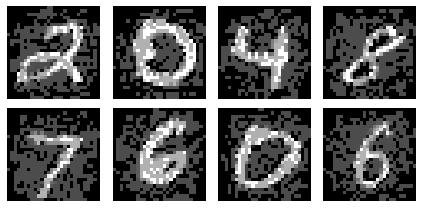

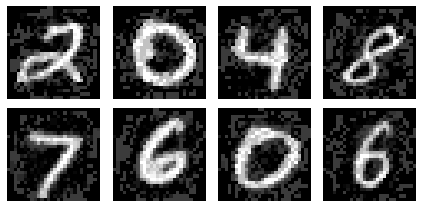

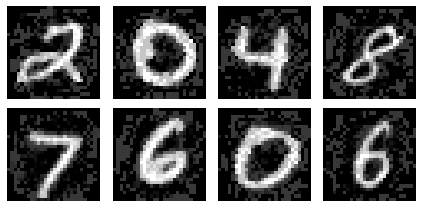

generation done.
starting evaluation.
----------------------
transfer model layer:  0
t:  1
Robustness(Clean): 0.46
Robustness(FGSM): 0.29
Robustness(PGD-10): 0.43
Robustness(PGD-100): 0.43
-------
t:  16
Robustness(Clean): 0.51
Robustness(FGSM): 0.30
Robustness(PGD-10): 0.49
Robustness(PGD-100): 0.50
-------
t:  256
Robustness(Clean): 0.72
Robustness(FGSM): 0.54
Robustness(PGD-10): 0.71
Robustness(PGD-100): 0.71
-------
t:  4096
Robustness(Clean): 0.84
Robustness(FGSM): 0.75
Robustness(PGD-10): 0.87
Robustness(PGD-100): 0.86
-------
t:  65536
Robustness(Clean): 0.87
Robustness(FGSM): 0.70
Robustness(PGD-10): 0.89
Robustness(PGD-100): 0.89
-------
t:  inf
Robustness(Clean): 0.84
Robustness(FGSM): 0.17
Robustness(PGD-10): 0.19
Robustness(PGD-100): 0.19
-------
----------------------
transfer model layer:  5
t:  1
Robustness(Clean): 0.27
Robustness(FGSM): 0.19
Robustness(PGD-10): 0.27
Robustness(PGD-100): 0.27
-------
t:  16
Robustness(Clean): 0.71
Robustness(FGSM): 0.62
Robustness(PGD-1

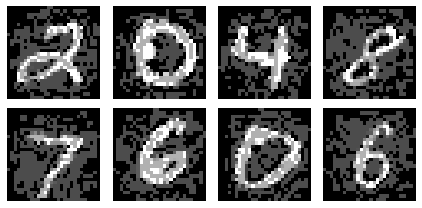

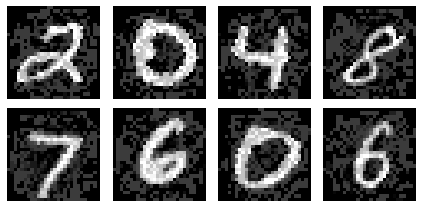

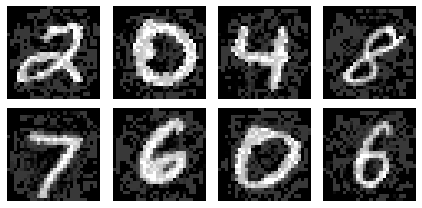

generation done.
starting evaluation.
----------------------
transfer model layer:  0
t:  1
Robustness(Clean): 0.46
Robustness(FGSM): 0.29
Robustness(PGD-10): 0.39
Robustness(PGD-100): 0.39
-------
t:  16
Robustness(Clean): 0.51
Robustness(FGSM): 0.30
Robustness(PGD-10): 0.42
Robustness(PGD-100): 0.42
-------
t:  256
Robustness(Clean): 0.72
Robustness(FGSM): 0.52
Robustness(PGD-10): 0.68
Robustness(PGD-100): 0.68
-------
t:  4096
Robustness(Clean): 0.84
Robustness(FGSM): 0.70
Robustness(PGD-10): 0.82
Robustness(PGD-100): 0.83
-------
t:  65536
Robustness(Clean): 0.87
Robustness(FGSM): 0.65
Robustness(PGD-10): 0.82
Robustness(PGD-100): 0.83
-------
t:  inf
Robustness(Clean): 0.84
Robustness(FGSM): 0.15
Robustness(PGD-10): 0.17
Robustness(PGD-100): 0.17
-------
----------------------
transfer model layer:  5
t:  1
Robustness(Clean): 0.27
Robustness(FGSM): 0.18
Robustness(PGD-10): 0.24
Robustness(PGD-100): 0.24
-------
t:  16
Robustness(Clean): 0.71
Robustness(FGSM): 0.58
Robustness(PGD-1

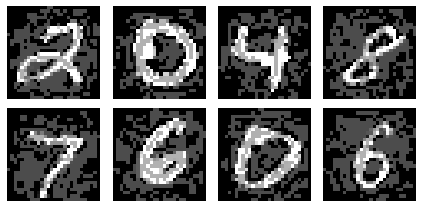

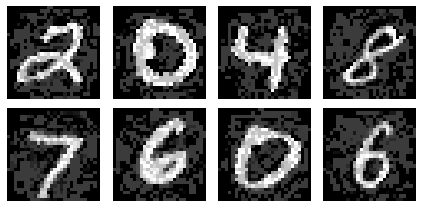

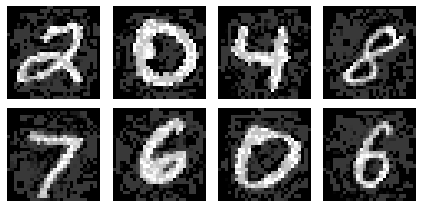

generation done.
starting evaluation.
----------------------
transfer model layer:  0
t:  1
Robustness(Clean): 0.46
Robustness(FGSM): 0.28
Robustness(PGD-10): 0.37
Robustness(PGD-100): 0.38
-------
t:  16
Robustness(Clean): 0.51
Robustness(FGSM): 0.30
Robustness(PGD-10): 0.39
Robustness(PGD-100): 0.40
-------
t:  256
Robustness(Clean): 0.72
Robustness(FGSM): 0.53
Robustness(PGD-10): 0.64
Robustness(PGD-100): 0.66
-------
t:  4096
Robustness(Clean): 0.84
Robustness(FGSM): 0.70
Robustness(PGD-10): 0.79
Robustness(PGD-100): 0.81
-------
t:  65536
Robustness(Clean): 0.87
Robustness(FGSM): 0.63
Robustness(PGD-10): 0.78
Robustness(PGD-100): 0.78
-------
t:  inf
Robustness(Clean): 0.84
Robustness(FGSM): 0.16
Robustness(PGD-10): 0.16
Robustness(PGD-100): 0.16
-------
----------------------
transfer model layer:  5
t:  1
Robustness(Clean): 0.27
Robustness(FGSM): 0.18
Robustness(PGD-10): 0.22
Robustness(PGD-100): 0.22
-------
t:  16
Robustness(Clean): 0.71
Robustness(FGSM): 0.58
Robustness(PGD-1

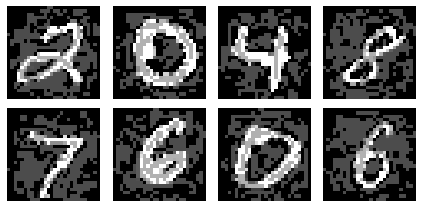

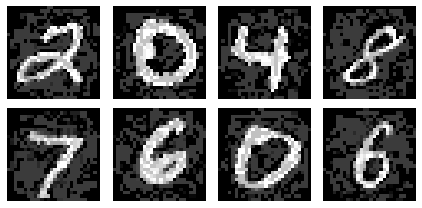

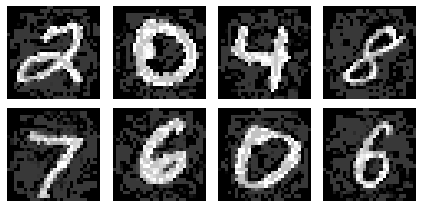

generation done.
starting evaluation.
----------------------
transfer model layer:  0
t:  1
Robustness(Clean): 0.46
Robustness(FGSM): 0.29
Robustness(PGD-10): 0.36
Robustness(PGD-100): 0.36
-------
t:  16
Robustness(Clean): 0.51
Robustness(FGSM): 0.30
Robustness(PGD-10): 0.37
Robustness(PGD-100): 0.39
-------
t:  256
Robustness(Clean): 0.72
Robustness(FGSM): 0.51
Robustness(PGD-10): 0.64
Robustness(PGD-100): 0.65
-------
t:  4096
Robustness(Clean): 0.84
Robustness(FGSM): 0.68
Robustness(PGD-10): 0.78
Robustness(PGD-100): 0.79
-------
t:  65536
Robustness(Clean): 0.87
Robustness(FGSM): 0.61
Robustness(PGD-10): 0.76
Robustness(PGD-100): 0.76
-------
t:  inf
Robustness(Clean): 0.84
Robustness(FGSM): 0.15
Robustness(PGD-10): 0.16
Robustness(PGD-100): 0.16
-------
----------------------
transfer model layer:  5
t:  1
Robustness(Clean): 0.27
Robustness(FGSM): 0.18
Robustness(PGD-10): 0.21
Robustness(PGD-100): 0.21
-------
t:  16
Robustness(Clean): 0.71
Robustness(FGSM): 0.58
Robustness(PGD-1

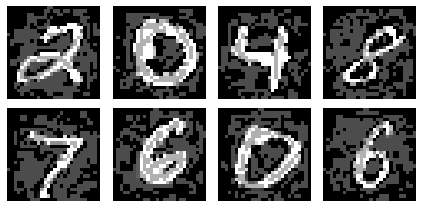

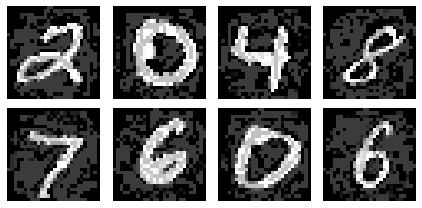

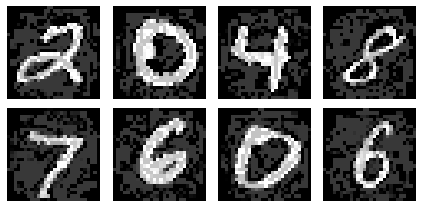

generation done.
starting evaluation.
----------------------
transfer model layer:  0
t:  1
Robustness(Clean): 0.46
Robustness(FGSM): 0.29
Robustness(PGD-10): 0.35
Robustness(PGD-100): 0.35
-------
t:  16
Robustness(Clean): 0.51
Robustness(FGSM): 0.30
Robustness(PGD-10): 0.36
Robustness(PGD-100): 0.37
-------
t:  256
Robustness(Clean): 0.72
Robustness(FGSM): 0.51
Robustness(PGD-10): 0.62
Robustness(PGD-100): 0.64
-------
t:  4096
Robustness(Clean): 0.84
Robustness(FGSM): 0.68
Robustness(PGD-10): 0.76
Robustness(PGD-100): 0.77
-------
t:  65536
Robustness(Clean): 0.87
Robustness(FGSM): 0.60
Robustness(PGD-10): 0.73
Robustness(PGD-100): 0.74
-------
t:  inf
Robustness(Clean): 0.84
Robustness(FGSM): 0.14
Robustness(PGD-10): 0.16
Robustness(PGD-100): 0.16
-------
----------------------
transfer model layer:  5
t:  1
Robustness(Clean): 0.27
Robustness(FGSM): 0.18
Robustness(PGD-10): 0.20
Robustness(PGD-100): 0.20
-------
t:  16
Robustness(Clean): 0.71
Robustness(FGSM): 0.57
Robustness(PGD-1

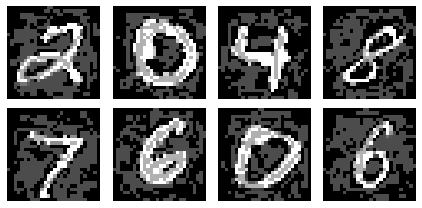

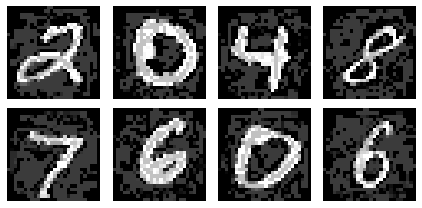

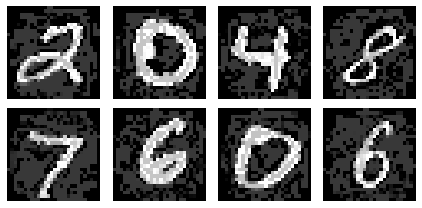

generation done.
starting evaluation.
----------------------
transfer model layer:  0
t:  1
Robustness(Clean): 0.46
Robustness(FGSM): 0.29
Robustness(PGD-10): 0.34
Robustness(PGD-100): 0.35
-------
t:  16
Robustness(Clean): 0.51
Robustness(FGSM): 0.30
Robustness(PGD-10): 0.36
Robustness(PGD-100): 0.37
-------
t:  256
Robustness(Clean): 0.72
Robustness(FGSM): 0.50
Robustness(PGD-10): 0.62
Robustness(PGD-100): 0.64
-------
t:  4096
Robustness(Clean): 0.84
Robustness(FGSM): 0.68
Robustness(PGD-10): 0.76
Robustness(PGD-100): 0.76
-------
t:  65536
Robustness(Clean): 0.87
Robustness(FGSM): 0.58
Robustness(PGD-10): 0.71
Robustness(PGD-100): 0.72
-------
t:  inf
Robustness(Clean): 0.84
Robustness(FGSM): 0.15
Robustness(PGD-10): 0.15
Robustness(PGD-100): 0.15
-------
----------------------
transfer model layer:  5
t:  1
Robustness(Clean): 0.27
Robustness(FGSM): 0.18
Robustness(PGD-10): 0.20
Robustness(PGD-100): 0.20
-------
t:  16
Robustness(Clean): 0.71
Robustness(FGSM): 0.57
Robustness(PGD-1

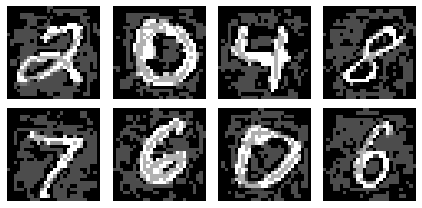

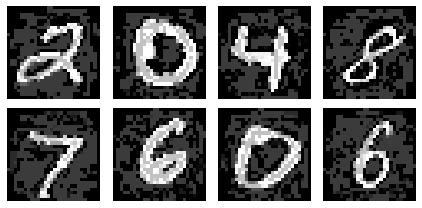

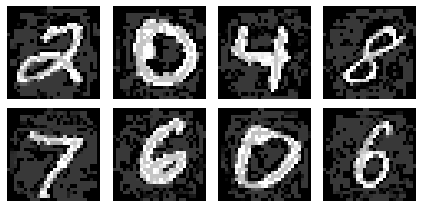

generation done.
starting evaluation.
----------------------
transfer model layer:  0
t:  1
Robustness(Clean): 0.46
Robustness(FGSM): 0.29
Robustness(PGD-10): 0.34
Robustness(PGD-100): 0.35
-------
t:  16
Robustness(Clean): 0.51
Robustness(FGSM): 0.30
Robustness(PGD-10): 0.35
Robustness(PGD-100): 0.37
-------
t:  256
Robustness(Clean): 0.72
Robustness(FGSM): 0.51
Robustness(PGD-10): 0.62
Robustness(PGD-100): 0.63
-------
t:  4096
Robustness(Clean): 0.84
Robustness(FGSM): 0.68
Robustness(PGD-10): 0.75
Robustness(PGD-100): 0.76
-------
t:  65536
Robustness(Clean): 0.87
Robustness(FGSM): 0.57
Robustness(PGD-10): 0.70
Robustness(PGD-100): 0.71
-------
t:  inf
Robustness(Clean): 0.84
Robustness(FGSM): 0.14
Robustness(PGD-10): 0.14
Robustness(PGD-100): 0.14
-------
----------------------
transfer model layer:  5
t:  1
Robustness(Clean): 0.27
Robustness(FGSM): 0.18
Robustness(PGD-10): 0.19
Robustness(PGD-100): 0.20
-------
t:  16
Robustness(Clean): 0.71
Robustness(FGSM): 0.57
Robustness(PGD-1

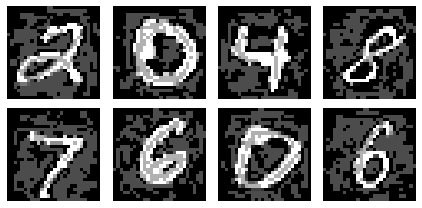

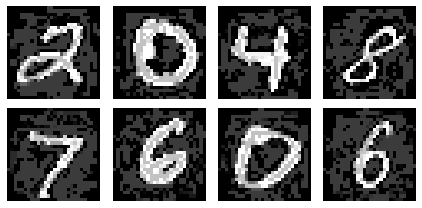

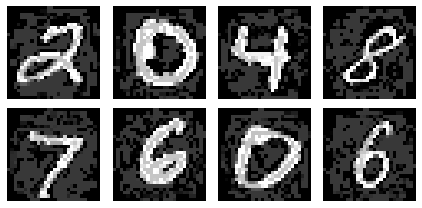

generation done.
starting evaluation.
----------------------
transfer model layer:  0
t:  1
Robustness(Clean): 0.46
Robustness(FGSM): 0.29
Robustness(PGD-10): 0.34
Robustness(PGD-100): 0.35
-------
t:  16
Robustness(Clean): 0.51
Robustness(FGSM): 0.30
Robustness(PGD-10): 0.35
Robustness(PGD-100): 0.36
-------
t:  256
Robustness(Clean): 0.72
Robustness(FGSM): 0.52
Robustness(PGD-10): 0.62
Robustness(PGD-100): 0.63
-------
t:  4096
Robustness(Clean): 0.84
Robustness(FGSM): 0.68
Robustness(PGD-10): 0.75
Robustness(PGD-100): 0.76
-------
t:  65536
Robustness(Clean): 0.87
Robustness(FGSM): 0.56
Robustness(PGD-10): 0.71
Robustness(PGD-100): 0.71
-------
t:  inf
Robustness(Clean): 0.84
Robustness(FGSM): 0.14
Robustness(PGD-10): 0.13
Robustness(PGD-100): 0.13
-------
----------------------
transfer model layer:  5
t:  1
Robustness(Clean): 0.27
Robustness(FGSM): 0.18
Robustness(PGD-10): 0.19
Robustness(PGD-100): 0.19
-------
t:  16
Robustness(Clean): 0.71
Robustness(FGSM): 0.57
Robustness(PGD-1

In [21]:
b = 0.18
W = 1.76
num_classes = 10

# layer = 5
clean_acc  = {}
fgsm_acc  = {}
pgd_10_acc  = {}
pgd_100_acc  = {}

save_samples(x_test, 'clean', 0)

for base_model_layer in range(0, 50, 5):
    print("****************")
    print("generating adv examples...")
    print("base model layer: ", base_model_layer)
    
    adv_x_FGSM, adv_x_PGD_10, adv_x_PGD_100 = gen_adv_x(model_layer=base_model_layer, d='row')
    
    save_samples(adv_x_FGSM,    'FGSM',    base_model_layer)
    save_samples(adv_x_PGD_10,  'PGD_10',  base_model_layer)
    save_samples(adv_x_PGD_100, 'PGD_100', base_model_layer)
    
    print("generation done.")
    print("starting evaluation.")
    for layer in range(0, 50, 5):
        print("----------------------")
        print("transfer model layer: ", layer)
        key = random.PRNGKey(0)

        b_std = np.sqrt(b)
        W_std = np.sqrt(W)

        init_fn, apply_fn, kernel_fn_trans = stax.serial(DenseGroup(layer, 1024, W_std, b_std))
        kernel_fn_trans = jit(kernel_fn_trans, static_argnums=(2,))
        
        def inv(k):
            #inverse with diag_reg
            return np.linalg.inv(k + diag_reg * np.eye(k.shape[0]))

        ntk_train_train_trans = kernel_fn_trans(x_train, x_train, 'ntk')
        ntk_train_train_inv_trans = inv(ntk_train_train_trans)
        
        for ts in time_steps:
            print("t: ", ts)
            clean_acc["base: %d, trans: %d, t: %s"%(base_model_layer, layer, str(ts))] = evaluate(x_train, x_test, model_fn=model_fn, kernel_fn=kernel_fn_trans, 
                                                                                             t=ts, c=0, attack_type='Clean')
            fgsm_acc["base: %d, trans: %d, t: %s"%(base_model_layer, layer, str(ts))] = evaluate(x_train, adv_x_FGSM, model_fn=model_fn, kernel_fn=kernel_fn_trans, 
                                                                                             t=ts, c=0, attack_type='FGSM')
            pgd_10_acc["base: %d, trans: %d, t: %s"%(base_model_layer, layer, str(ts))] = evaluate(x_train, adv_x_PGD_10,model_fn=model_fn, kernel_fn=kernel_fn_trans, 
                                                                                             t=ts, c=0, attack_type='PGD-10')
            pgd_100_acc["base: %d, trans: %d, t: %s"%(base_model_layer, layer, str(ts))] = evaluate(x_train, adv_x_PGD_100, model_fn=model_fn, kernel_fn=kernel_fn_trans, 
                                                                                             t=ts, c=0, attack_type='PGD-100')
            print("-------")
        #pgd_100_acc.append(evaluate(x_train, adv_x_PGD_1000, model_fn=model_fn, kernel_fn=kernel_fn_trans, t=t, c=0, attack_type='PGD-1000'))

In [22]:
import pickle as pkl

pkl.dump(clean_acc  , open('mnist_row_clean', 'wb'), protocol=pkl.HIGHEST_PROTOCOL)
pkl.dump(fgsm_acc   , open('mnist_row_fgsm', 'wb'), protocol=pkl.HIGHEST_PROTOCOL)
pkl.dump(pgd_10_acc , open('mnist_row_pgd10', 'wb'), protocol=pkl.HIGHEST_PROTOCOL)
pkl.dump(pgd_100_acc, open('mnist_row_pgd100', 'wb'), protocol=pkl.HIGHEST_PROTOCOL)

In [37]:
tt = []
for ts in time_steps:
    bb = []
    for base_model_layer in range(0, 50, 5):
        trans = []
        for layer in range(0, 50, 5):
            trans.append(onp.asarray(pgd_100_acc["base: %d, trans: %d, t: %s"%(base_model_layer, layer, str(ts))]))
        bb.append(trans)
    bb = onp.asarray(bb)
    # print(bb)
    onp.savetxt("tmp_%s.csv"%(ts), bb, delimiter=",", fmt="%.3f")

In [66]:
def plt_samples(arr):
    fig, axs = plt.subplots(2, 4, figsize=(6, 3), sharex=True)
    for row, ax in enumerate(axs):
        for idx, a in enumerate(ax):
            img = arr[idx + row*4].reshape(img_shape)
            a.axis('off')
            a.xaxis.set_visible(False)
            a.yaxis.set_visible(False)
            a.imshow(img, cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

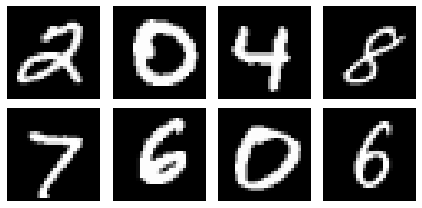

In [67]:
plt_samples(x_test)

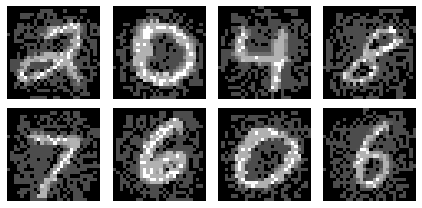

In [70]:
plt_samples(adv_x_FGSM)

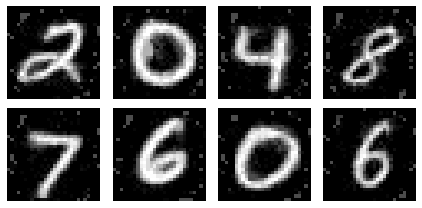

In [68]:
plt_samples(adv_x_PGD_10)

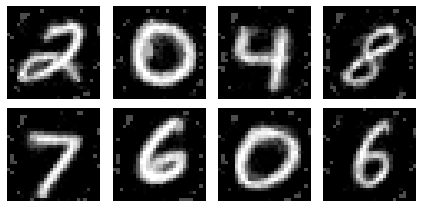

In [69]:
plt_samples(adv_x_PGD_100)